# Статистический анализ данных 
## Описание проекта
Мы предстаем аналитиком компании, для корректировки дальнейшего бюджета необходимо провести ислледование тарифов по выборке клиентов.
## Цель проекта
Проанализировать поведение клиентов по выборке и сделать вывод - какой тариф лучше.
## Задача проекта
Подготовить и проанализировать предоставленные данные, после проверить необходимые гипотезы и сделать выводы на их основании.

## План проекта

- Выполним **предобработку данных**:
  - Приведем данные к нужным типам;
  - Найдем и исправим ошибки в данных, если они есть.
- Произведем **необходимые расчеты**:
- **Проанализируем** предоставленные данные, исходя из выборки
- Проверим **гипотезы**, являющиеся ключевыми в данном иследовании
- Подведем все важные **выводы** по данному проекту.


# Описание данных

Таблица users (информация о пользователях):
`user_id` — уникальный идентификатор пользователя  
`first_name` — имя пользователя  
`last_name` — фамилия пользователя  
`age` — возраст пользователя (годы)  
`reg_date` — дата подключения тарифа (день, месяц, год)  
`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)  
`city` — город проживания пользователя  
`tariff` — название тарифного плана  

Таблица calls (информация о звонках):
`id` — уникальный номер звонка  
`call_date` — дата звонка  
`duration` — длительность звонка в минутах  
`user_id` — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
`id` — уникальный номер сообщения  
`message_date` — дата сообщения  
`user_id` — идентификатор пользователя, отправившего сообщение  

Таблица internet (информация об интернет-сессиях):
`id` — уникальный номер сессии  
`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)  
`session_date` — дата интернет-сессии  
`user_id` — идентификатор пользователя  

Таблица tariffs (информация о тарифах):
`tariff_name` — название тарифа  
`rub_monthly_fee` — ежемесячная абонентская плата в рублях  
`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату  
`messages_included` — количество сообщений в месяц, включённых в абонентскую плату  
`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)  
`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)  
`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета  
`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


## Тело проекта
### Настроим необходимое в работе окружение

In [1]:
import pandas as pd # Импортируем библиотеку pandas для работы с таблицами
import numpy as np # для работы с массивами данных
from scipy import stats as st # для работы со статистикой
import matplotlib.pyplot as plt # Для работы с визуализацией данных 
import seaborn as sns
import warnings # Отключим предупреждения платформы
warnings.simplefilter('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5 # Сразу установим увеличенный дефолтный размер графиков
from functools import reduce #для корректного объединения таблиц

### Изучение данных из файла
Выполним корректное открытие всех датасетов представленных нам для работы:


In [2]:
pd.set_option('display.max_columns', 50) 
try:

  calls = pd.read_csv('/work/calls.csv')  # информация о звонках
  users = pd.read_csv('/work/users.csv')  # информация о пользователях
  messages = pd.read_csv('/work/messages.csv')  # информация о сообщениях
  internet = pd.read_csv('/work/internet.csv')  # информация об интернет-сессиях
  tariffs = pd.read_csv('/work/tariffs.csv')  # информация о тарифах
except:
  calls = pd.read_csv('/datasets/calls.csv')  # информация о звонках
  users = pd.read_csv('/datasets/users.csv')  # информация о пользователях
  messages = pd.read_csv('/datasets/messages.csv')  # информация о сообщениях
  internet = pd.read_csv('/datasets/internet.csv')  # информация об интернет-сессиях
  tariffs = pd.read_csv('/datasets/tariffs.csv')  # информация о тарифах

In [3]:
# выведем все датасеты для первичного ознакомления
print('таблица calls')
display(calls.head())
print(' ')
print('таблица users')
display(users.head())
print(' ')
print('таблица messages')
display(messages.head())
print(' ')
print('таблица internet')
display(internet.head())
print(' ')
print('таблица tariffs')
display(tariffs.head())

таблица calls


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


 
таблица users


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


 
таблица messages


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


 
таблица internet


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


 
таблица tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [4]:
# а также ознакомимся с основными их характеристиками
print('Характеристики таблицы calls')
calls.info()
print('')
print('Характеристики таблицы users')
users.info()
print('')
print('Характеристики таблицы messages')
messages.info()
print('')
print('Характеристики таблицы internet')
internet.info()
print('')
print('Характеристики таблицы tariffs')
tariffs.info()

Характеристики таблицы calls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

Характеристики таблицы users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), o

### Предобработка данных

#### Пропущенные значения
Обнаружены пропущенные значения только в таблице 'users.csv' в столбце 'churn_date' однако данные пропуски означают что тариф все еще продолжает действовать. Оставим их.



In [5]:
users['churn_date'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: churn_date, dtype: object

#### Изменение типов данных

Приступая к изменению типов данных перечислим столбцы в которых необходимо будет произвести замену:
- Таблица 'calls.csv':
  - столбец 'call_date' : в тип **datetime**
- Таблица 'users.csv':
  - столбец 'churn_date' : в тип **datetime**
  - столбец 'reg_date' : в тип **datetime**
- Таблица 'messages.csv':
  - столбец 'message_date' : в тип **datetime**
- Таблица 'internet':
  - столбец 'session_date' : в тип **datetime**

**Выполним все эти преобразования для корректной дальнейшей работы с данными столбцами**


In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y.%m.%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y.%m.%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%d')

#### Поиск и исправление ошибок в данных

Ошибкой в данных являлись некорректные типы данных в столбцах, описанные выше. Причиной появления таких ошибок можно назвать не до конца отлаженный сбор данный и неправильное их интерпретированние в контексте конечного форматирования.
В остальном данные выглядят нормальными и не нуждаются в корректировке.


#### Расчеты звонков и минут для каждого пользователя по месяцам

Для выполнения данных рассчетов воспользуемся методом сводных таблиц перед этим не забыв окгрулить звонки по правилу: `"«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута."`

In [7]:
calls['duration'] = np.ceil(calls['duration'])
calls['month'] = calls['call_date'].dt.month #посчитаем месяца каждого звонка
display(calls.head()) # проверим что месяца посчитались правильно
user_calls = calls.pivot_table(index=['user_id','month'], values='duration', aggfunc=['count','sum']) #сведем с нужными функциями
user_calls.columns = ['count_calls', 'sum_calls'] # уберем двухэтажные названия
user_calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


count_calls  sum_calls
user_id month                        
1000    5               22      159.0
        6               43      172.0
        7               47      340.0
        8               52      408.0
        9               58      466.0

#### Расчет количества отправленных сообщений по месяцам

Аналогичный алгоритм применим и здесь

In [8]:
messages['month'] = messages['message_date'].dt.month #посчитаем месяца каждого сообщения
user_messages = messages.pivot_table(index=['user_id','month'], values='id', aggfunc=['count']) #сведем с нужными функциями
user_messages.columns = ['count_messages'] # уберем двухэтажные названия
user_messages.head()

count_messages
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57

#### Расчет объема израсходованного интернет-трафика по месяцам

Мы помним, что: `«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.`   
И конечно, что: `1 гигабайт = 1024 мегабайт`

Однако, так как окргулять будем общую сумму за месяц, для начала посчитаем мегабайтами:

In [9]:
internet['month'] = internet['session_date'].dt.month #посчитаем месяца каждой интернет-сессии
user_internet = internet.pivot_table(index=['user_id','month'], values='mb_used', aggfunc=['sum']) #сведем с нужными функциями
user_internet.columns = ['sum'] # уберем двухэтажные названия
user_internet['sum'] /= 1024 # переведем в гигабайты
user_internet['sum'] = np.ceil(user_internet['sum']) # округлим по правилу проекта
user_internet.columns = ['sum_internet_gb']
user_internet.head()

sum_internet_gb
user_id month                 
1000    5                  3.0
        6                 23.0
        7                 14.0
        8                 14.0
        9                 15.0

#### Расчет выручки с каждого пользователя по месяцам

Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану

Для начала объедими наши сводные таблицы

In [10]:
data_frames = [user_calls, user_messages, user_internet, users]
month_traffic = reduce(lambda  left,right: pd.merge(left,right,on=['user_id'], how='outer'), data_frames)
# удалим лишние столбцы, чтобы ничего не мешало
del month_traffic['age']
del month_traffic['churn_date']
del month_traffic['first_name']
del month_traffic['last_name']
del month_traffic['reg_date']
print(month_traffic.info())
month_traffic.head() #проверим что получилось

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207179 entries, 0 to 207178
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          207179 non-null  int64  
 1   count_calls      206909 non-null  float64
 2   sum_calls        206909 non-null  float64
 3   count_messages   203276 non-null  float64
 4   sum_internet_gb  207113 non-null  float64
 5   city             207179 non-null  object 
 6   tariff           207179 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 12.6+ MB
None


,user_id,count_calls,sum_calls,count_messages,sum_internet_gb,city,tariff
0,1000,22.0,159.0,22.0,3.0,Краснодар,ultra
1,1000,22.0,159.0,22.0,23.0,Краснодар,ultra
2,1000,22.0,159.0,22.0,14.0,Краснодар,ultra
3,1000,22.0,159.0,22.0,14.0,Краснодар,ultra
4,1000,22.0,159.0,22.0,15.0,Краснодар,ultra


После этого вычтем беслпатный лимит который хранится в таблице `tariffs`

Воспользуемся функцией которая будет проверять какой тариф у клиента и после производить необходимые расчеты

In [11]:
def revenue (month_traffic):
  tariff = month_traffic['tariff']
  minutes_used = month_traffic['sum_calls']
  gb_used = month_traffic['sum_internet_gb']
  messages_used = month_traffic['count_messages']
  if tariff == 'smart':
    if messages_used > tariffs.loc[0]['messages_included']:
      messages_debt = (messages_used - tariffs.loc[0]['messages_included']) * tariffs.loc[0]['rub_per_message']
    else:
      messages_debt = 0
    if minutes_used > tariffs.loc[0]['minutes_included']:
      minutes_debt = (minutes_used - tariffs.loc[0]['minutes_included']) * tariffs.loc[0]['rub_per_minute']
    else:
      minutes_debt = 0
    if gb_used > tariffs.loc[0]['mb_per_month_included'] / 1024:
      internet_debt = np.ceil((gb_used - tariffs.loc[0]['mb_per_month_included'] / 1024)) * tariffs.loc[0]['rub_per_gb']
    else:
      internet_debt = 0
    return messages_debt + minutes_debt + internet_debt + tariffs.loc[0]['rub_monthly_fee']
  elif tariff == 'ultra':
    if messages_used > tariffs.loc[1]['messages_included']:
      messages_debt = (messages_used - tariffs.loc[1]['messages_included']) * tariffs.loc[1]['rub_per_message']
    else:
      messages_debt = 0
    if minutes_used > tariffs.loc[1]['minutes_included']:
      minutes_debt = (minutes_used - tariffs.loc[1]['minutes_included']) * tariffs.loc[1]['rub_per_minute']
    else:
      minutes_debt = 0
    if gb_used > tariffs.loc[1]['mb_per_month_included'] / 1024:
      internet_debt = np.ceil((gb_used - tariffs.loc[1]['mb_per_month_included'] / 1024)) * tariffs.loc[1]['rub_per_gb']
    else:
      internet_debt = 0
  return messages_debt + minutes_debt + internet_debt + tariffs.loc[1]['rub_monthly_fee']

month_traffic['total_revenue'] = month_traffic.apply(revenue, axis=1)


In [12]:
month_traffic.sort_values(by='total_revenue', ascending=False).head() # выведем результат

,user_id,count_calls,sum_calls,count_messages,sum_internet_gb,city,tariff,total_revenue
202930,1486,133.0,1007.0,96.0,38.0,Нижний Новгород,smart,6809.0
202933,1486,133.0,1007.0,83.0,38.0,Нижний Новгород,smart,6770.0
202927,1486,133.0,1007.0,1.0,38.0,Нижний Новгород,smart,6671.0
202929,1486,133.0,1007.0,96.0,36.0,Нижний Новгород,smart,6409.0
202932,1486,133.0,1007.0,83.0,36.0,Нижний Новгород,smart,6370.0


In [13]:
month_traffic['total_revenue'].value_counts().head()

1950.0    54246
550.0     30718
950.0      6530
750.0      5272
1150.0     5168
Name: total_revenue, dtype: int64

#### Вывод по предобработке данных

Данные были полностью предобработаны и подготовлены к анализу. Было выполнено:
- Обнаружены и убраны пропущенные значения в таблицах и столбцах:
  - в таблице 'users.csv' в столбце 'churn_date'
- Изменены типы данных:
  - Таблица 'calls.csv':
    - столбец 'call_date' : в тип **datetime**
  - Таблица 'users.csv':
    - столбец 'churn_date' : в тип **datetime**
    - столбец 'reg_date' : в тип **datetime**
  - Таблица 'messages.csv':
    - столбец 'message_date' : в тип **datetime**
  - Таблица 'internet':
    - столбец 'session_date' : в тип **datetime**
- Произведен поиск дополнительных ошибок в данных, однако в связи с отсутствием результата был удален из иследования.
- Выполнены расчеты данных и добавлено в таблицу:
  - Расчеты звонков и минут для каждого пользователя по месяцам
  - Расчет объема израсходованного интернет-трафика по месяцам
  - Расчет выручки с каждого пользователя по месяцам

### Анализ данных

#### Опишем поведение клиентов оператора, исходя из выборки. 
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

#### Расчеты среднего количества минут, сообщений и ГБ

Выполним расчеты среднего количества минут, сообщений и ГБ интернета для пользователей каждого тарифа:

In [14]:
smart_users = month_traffic.query('tariff == "smart"')
smart_minutes_avg = smart_users['sum_calls'].mean()
smart_messages_avg = smart_users['count_messages'].mean()
smart_internet_avg = smart_users['sum_internet_gb'].mean()

ultra_users = month_traffic.query('tariff == "ultra"')
ultra_minutes_avg = ultra_users['sum_calls'].mean()
ultra_messages_avg = ultra_users['count_messages'].mean()
ultra_internet_avg = ultra_users['sum_internet_gb'].mean()

print(f'Для тарифа SMART среднее количество минут: {round(smart_minutes_avg)} минут, количество СМС: {round(smart_messages_avg)} шт, а объем интернет траффика равен: {round(smart_internet_avg)} ГБ')
print(f'Для тарифа ULTRA среднее количество минут: {round(ultra_minutes_avg)} минут, количество СМС: {round(ultra_messages_avg)} шт, а объем интернет траффика равен: {round(ultra_internet_avg)} ГБ')

Для тарифа SMART среднее количество минут: 418 минут, количество СМС: 39 шт, а объем интернет траффика равен: 16 ГБ
Для тарифа ULTRA среднее количество минут: 569 минут, количество СМС: 57 шт, а объем интернет траффика равен: 20 ГБ


#### Расчеты дисперсии 

Выполним расчеты дисперсии для каждого параметра для двух тарифов:
`так как работаем с выборкой не забудем поставить параметр ddof=1`

In [15]:
smart_minutes_var = np.var(smart_users['sum_calls'], ddof=1)
smart_messages_var = np.var(smart_users['count_messages'], ddof=1)
smart_internet_var = np.var(smart_users['sum_internet_gb'], ddof=1)
ultra_minutes_var = np.var(ultra_users['sum_calls'], ddof=1)
ultra_messages_var = np.var(ultra_users['count_messages'], ddof=1)
ultra_internet_var = np.var(ultra_users['sum_internet_gb'], ddof=1)

print(f'Для тарифа SMART дисперсия минут равна {round(smart_minutes_var,2)}, СМС {round(smart_messages_var,2)}, Интернет-траффика {round(smart_internet_var,2)}')
print(f'Для тарифа ULTRA дисперсия минут равна {round(ultra_minutes_var,2)}, СМС {round(ultra_messages_var,2)}, Интернет-траффика {round(ultra_internet_var,2)}')

Для тарифа SMART дисперсия минут равна 33748.57, СМС 661.08, Интернет-траффика 29.19
Для тарифа ULTRA дисперсия минут равна 89191.57, СМС 1817.9, Интернет-траффика 81.73


#### Расчеты стандартного отклонения

И проведем расчеты стандартного отклонения для каждого параметра для двух тарифов:

In [16]:
smart_minutes_dev = np.std(smart_users['sum_calls'], ddof=1)
smart_messages_dev = np.std(smart_users['count_messages'], ddof=1)
smart_internet_dev = np.std(smart_users['sum_internet_gb'], ddof=1)
ultra_minutes_dev = np.std(ultra_users['sum_calls'], ddof=1)
ultra_messages_dev = np.std(ultra_users['count_messages'], ddof=1)
ultra_internet_dev = np.std(ultra_users['sum_internet_gb'], ddof=1)

print(f'Для тарифа SMART стандартное отклонение минут равно {round(smart_minutes_dev,2)}, СМС {round(smart_messages_dev,2)}, Интернет-траффика {round(smart_internet_dev,2)}')
print(f'Для тарифа ULTRA стандартное отклонение минут равно {round(ultra_minutes_dev,2)}, СМС {round(ultra_messages_dev,2)}, Интернет-траффика {round(ultra_internet_dev,2)}')

Для тарифа SMART стандартное отклонение минут равно 183.71, СМС 25.71, Интернет-траффика 5.4
Для тарифа ULTRA стандартное отклонение минут равно 298.65, СМС 42.64, Интернет-траффика 9.04


Построим гистограммы для каждого параметра сразу по двум тарифам:

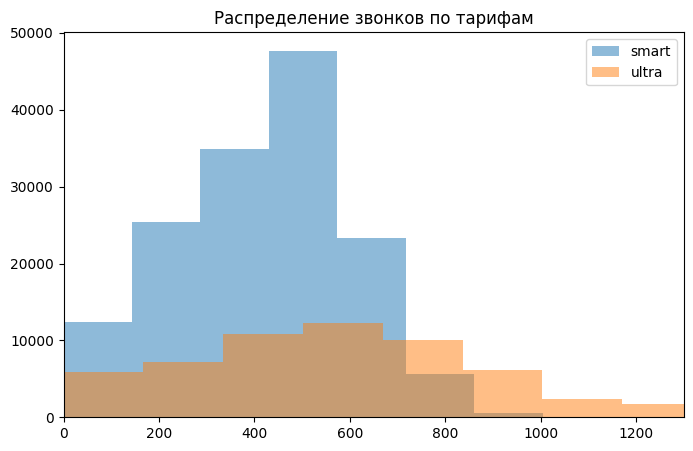

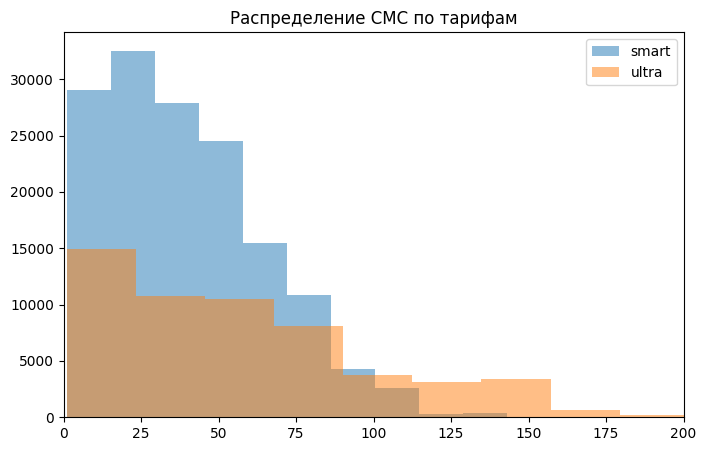

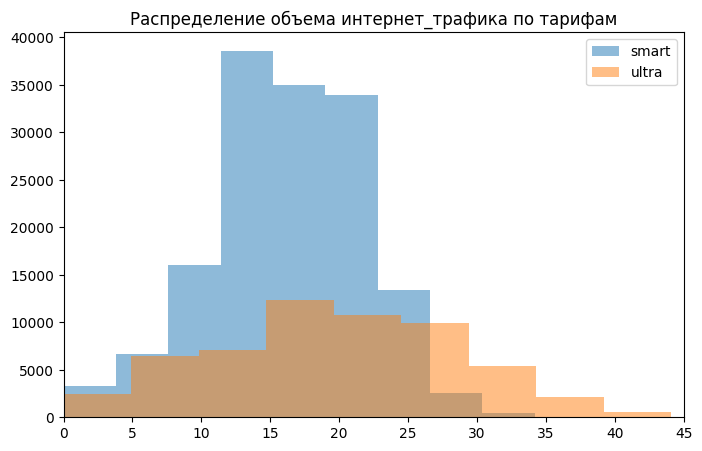

In [17]:
plt.hist(smart_users['sum_calls'], alpha=0.5, label='smart')
plt.hist(ultra_users['sum_calls'], alpha=0.5, label='ultra')
plt.legend()
plt.xlim(0, 1300)
plt.title('Распределение звонков по тарифам')
plt.show()

plt.hist(smart_users['count_messages'], alpha=0.5, label='smart')
plt.hist(ultra_users['count_messages'], alpha=0.5, label='ultra')
plt.legend()
plt.xlim(0, 200)
plt.title('Распределение СМС по тарифам')
plt.show()

plt.hist(smart_users['sum_internet_gb'], alpha=0.5, label='smart')
plt.hist(ultra_users['sum_internet_gb'], alpha=0.5, label='ultra')
plt.legend()
plt.xlim(0, 45)
plt.title('Распределение объема интернет_трафика по тарифам')
plt.show()


#### Вывод по анализу данных

- Определили среднее количество минут, смс и ГБ для пользователей каждого тарифа:
  - Для тарифа __SMART__ среднее количество минут: 418 минут, количество СМС: 39 шт, а объем интернет траффика равен: 16 ГБ
  - Для тарифа __ULTRA__ среднее количество минут: 569 минут, количество СМС: 57 шт, а объем интернет траффика равен: 20 ГБ

- Рассчитали дисперсию для каждого параметра:
  - Для тарифа __SMART__ дисперсия минут равна 33748.57, СМС 661.14, Интернет-траффика 29.18
  - Для тарифа __ULTRA__ дисперсия минут равна 89191.57, СМС 1804.56, Интернет-траффика 81.81

- Произвели расчет стандартного отклонения для каждого параметра:
  - Для тарифа SMART стандартное отклонение минут равно 183.71, СМС 25.71, Интернет-траффика 5.40
  - Для тарифа ULTRA стандартное отклонение минут равно 298.64, СМС 42.48, Интернет-траффика 9.04

- Выполнили построение диаграм для наглядного распределение параметров.

Данный анализ показал, что:
- Ответом на вопрос "Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?" становится то, что:
  - для пользователей тарифа Smart в месяц требуется:
    - от 0 до 800 минут звонков 
    - от 0 до 100 смс
    - от 5 до 27 ГБ интернет трафика 
  - для пользователей тарифа Ultra в месяц требуется:
    - от 0 до 1000 минут звонков
    - от 0 до 150 смс
    - от 5 до 40 ГБ интернет трафика

- Распеределения в графиках расположились следующим образом:
  - Распределение звонков и интернета можно интерпретировать как нормальное, пики находятся в пределах средних значений, и расходятся с уменьшением в обе стороны.
  - Распределение СМС сообщений можно интерпретировать как нормальное со скошенностью вправо, то есть с положительной скошенностью.

### Проверка гипотез
Проверим гипотезы:
1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
Пороговое значение alpha зададим 0,05 общепринятое с поправкой на то, что данные учебные не всегда отличаются чистотой.

И Поясним:
- Как мы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.


Так как в нашем исследовании взята выборка, мы будем судить по ней о генеральной совокупности - а точнее, о её статистических параметрах.



#### Гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сравним дисперсии выборок до проверки гипотез (для параметра equal_var) c помощью стат.теста Левене и теста Барлетта

In [18]:
print(st.levene(smart_users['total_revenue'], ultra_users['total_revenue']))
print(st.bartlett(smart_users['total_revenue'], ultra_users['total_revenue']))

LeveneResult(statistic=44101.57225629746, pvalue=0.0)
BartlettResult(statistic=50025.162127239564, pvalue=0.0)


Сформулируем нулевую гипотезу:
Средняя выручка пользователей тарифа "Ультра" __равна__ средней выручке пользователей тарифа "Смарт"

Сформулируем альтернативную двустороннюю гипотезу (т.к. отклонение может быть в обе стороны):
Средняя выручка пользователей тарифа "Ультра" __не равна__ средней выручке пользователей тарифа "Смарт"

Воспользуемся проверкой гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам методом `st.ttest_ind`

In [19]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    smart_users['total_revenue'], 
    ultra_users['total_revenue'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.0
Отвергаем нулевую гипотезу


##### Поясним:

Формулировали нулевую гипотезу H₀ следующим образом: __Средняя выручка пользователей тарифа "Ультра" равна средней выручке пользователей тарифа "Смарт"__ потому что: H₀ всегда формулируется так, чтобы использовать знак равенства. Другими словами, чтобы все данные лежали в районе изначально предполагаемого значения. 
Альтернативную гипотезу формулировали такой, чтоб она могла быть принята в случае отвержения нулевой гипотезы. 

Критерий для проверки гипотезы, то есть решающее правило (метод), отвергающее или принимающее нулевую гипотезу на основе выборочных наблюдений выбирали по принципу: Если средняя выручка (то есть среднее двух ген. совокупностей) окажется равно между пользователями двух тарифов, то прнимаем нашу нулевую гипотезу. Если нет (отклонение в любую сторону), то отвергаем её.

##### Результат проверки гипотезы

Показал нам что, нулевая гипотеза будет отвергнута, что означает: выручка по пользователям двух тарифов отличается. 

#### Гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформулируем нулевую гипотезу: Средняя выручка пользователей из Москвы __равна__  средней выручке пользователей из других регионов

Сформулируем альтернативную двустороннюю гипотезу (т.к. отклонение может быть в обе стороны): Средняя выручка пользователей из Москвы __не равна__  средней выручке пользователей из других регионов

Воспользуемся проверкой гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам методом st.ttest_ind

Сначала создадим два массива, для пользователей из Москвы, и для всех остальных:

In [20]:
month_traffic_msc = month_traffic.query('city == "Москва"')
month_traffic_msc.head()

,user_id,count_calls,sum_calls,count_messages,sum_internet_gb,city,tariff,total_revenue
512,1001,59.0,430.0,NaN,18.0,Москва,smart,1150.0
513,1001,59.0,430.0,NaN,14.0,Москва,smart,550.0
514,1001,63.0,414.0,NaN,18.0,Москва,smart,1150.0
515,1001,63.0,414.0,NaN,14.0,Москва,smart,550.0
859,1003,55.0,380.0,37.0,9.0,Москва,ultra,1950.0


Сравним дисперсии выборок до проверки гипотез (для параметра equal_var) c помощью стат.теста Левене и теста Барлетта

In [21]:
print(st.levene(month_traffic_msc['total_revenue'], month_traffic['total_revenue']))
print(st.bartlett(month_traffic_msc['total_revenue'], month_traffic['total_revenue']))

LeveneResult(statistic=264.4095470824055, pvalue=2.017541973604445e-59)
BartlettResult(statistic=7.06751876858001, pvalue=0.00784938841152376)


In [22]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    month_traffic_msc['total_revenue'], 
    month_traffic['total_revenue'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 6.183517691218455e-124
Отвергаем нулевую гипотезу


##### Поясним:

Формулировали нулевую гипотезу H₀ следующим образом: __Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов__ потому что: H₀ всегда формулируется так, чтобы использовать знак равенства. Другими словами, чтобы все данные лежали в районе изначально предполагаемого значения. 
Альтернативную гипотезу формулировали такой, чтоб она могла быть принята в случае отвержения нулевой гипотезы. 

Критерий для проверки гипотезы, то есть решающее правило (метод), отвергающее или принимающее нулевую гипотезу на основе выборочных наблюдений выбирали по принципу: Если средняя выручка (то есть среднее двух ген. совокупностей) пользвателей из Москвы окажется равна средней выручке по пользователям остальных регионов, то прнимаем нашу нулевую гипотезу. Если нет (отклонение в любую сторону), то отвергаем её.

##### Результат проверки гипотезы

Показал нам что, нулевая гипотеза будет отвергнута, что означает: выручка по пользователям Москвы отличается от пользователей остальных регионов. 

# Общий вывод

В данном исследовании мы:
- Ознакомились с данными и выполнили их полную предобработку:
  - Обнаружены и убраны пропущенные значения в таблицах и столбцах:
    - в таблице 'users.csv' в столбце 'churn_date'
  - Изменены типы данных:
    - Таблица 'calls.csv':
     - столбец 'call_date' : в тип **datetime**
   - Таблица 'users.csv':
     - столбец 'churn_date' : в тип **datetime**
     - столбец 'reg_date' : в тип **datetime**
   - Таблица 'messages.csv':
     - столбец 'message_date' : в тип **datetime**
   - Таблица 'internet':
     - столбец 'session_date' : в тип **datetime**
  - Произведен поиск дополнительных ошибок в данных, однако в связи с отсутствием результата был удален из иследования.
  - Выполнены расчеты данных и добавлено в таблицу:
    - Расчеты звонков и минут для каждого пользователя по месяцам
    - Расчет объема израсходованного интернет-трафика по месяцам
    - Расчет выручки с каждого пользователя по месяцам

По результатам анализа данных выяснили:
- Определили среднее количество минут, смс и ГБ для пользователей каждого тарифа:
  - Для тарифа __SMART__ среднее количество минут: 418 минут, количество СМС: 39 шт, а объем интернет траффика равен: 16 ГБ
  - Для тарифа __ULTRA__ среднее количество минут: 569 минут, количество СМС: 57 шт, а объем интернет траффика равен: 20 ГБ

- Рассчитали дисперсию для каждого параметра:
  - Для тарифа __SMART__ дисперсия минут равна 33748.57033534429, СМС 661.1465997164485, Интернет-траффика 29.189210840223488
  - Для тарифа __ULTRA__ дисперсия минут равна 89191.57224399726, СМС 1804.5630799198923, Интернет-траффика 81.81435542003456

- Произвели расчет стандартного отклонения для каждого параметра:
  - Для тарифа SMART стандартное отклонение минут равно 183.7078396131866, СМС 25.712771140358413, Интернет-траффика 5.402704030411391
  - Для тарифа ULTRA стандартное отклонение минут равно 298.64958102096386, СМС 42.48014924549927, Интернет-траффика 9.045128822744017

- Выполнили построение диаграм для наглядного распределение параметров.

Данный анализ показал, что:
- Ответом на вопрос "Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?" становится то, что:
  - для пользователей тарифа Smart в месяц требуется:
    - от 0 до 800 минут звонков 
    - от 0 до 100 смс
    - от 5 до 27 ГБ интернет трафика 
  - для пользователей тарифа Ultra в месяц требуется:
    - от 0 до 1000 минут звонков
    - от 0 до 150 смс
    - от 5 до 40 ГБ интернет трафика

- Распеределения в графиках расположились следующим образом:
  - Распределение звонков и интернета можно интерпретировать как нормальное, пики находятся в пределах средних значений, и расходятся с уменьшением в обе стороны.
  - Распределение СМС сообщений можно интерпретировать как нормальное со скошенностью вправо, то есть с положительной скошенностью.

Проверка гипотез показала нам, что:

Выручка по пользователям тарифов "Смарт" и "Ультра" отличается, также как и выручка пользователей Москвы и осталных регионов.

Общим выводом из работы: 
Становится ответ на вопрос: "Какой тариф лучше?" 
Если критерием оценки задать - общую выручку, то средняя выручка с тарифа "Ультра" больше (2035 у тарифа "Ультра", против 1234 у тарифа "Смарт")
Однако общая выручка больше у тарифа "Смарт" (~185202373 у тарифа "Смарт", против 115798950 у тарифа "Ультра")

Что делает затруднительным ответ на такой вопрос. Но наталкивает нас на мысль о проведении дополнительного исследования потенциала тарифа "Ультра" при дополнительном привлечении клиентов, ведь при расширеннии аудитории у данного тарифа, суммарная выручка будет практически вдвое большей, при одинаковом количестве человек, при сравнении с тарифом "Смарт"

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`)
- [x]  данные приведены к нужным типам;
- [x]  найдены и исправлены ошибки в данных
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано для каждого пользователя: количество сделанных звонков и израсходованных минут разговора по месяцам;
- [x]  посчитано для каждого пользователя: количество отправленных сообщений по месяцам
- [x]  посчитано для каждого пользователя: объем израсходованного интернет-трафика по месяцам
- [x]  посчитано для каждого пользователя: помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).
- [x]  описано поведение клиентов оператора, исходя из выборки
- [x]  сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- [x]  посчитано среднее количество, дисперсию и стандартное отклонение
- [x]  построены гистограммы. описаны распределения.
- [x]  проверена гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- [x]  проверена гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
- [x]  есть пояснение: как мы формулировали нулевую и альтернативную гипотезы;
- [x]  есть пояснение: какой критерий использовали для проверки гипотез и почему. 
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2c2f7678-02fc-499e-9e48-74288c4f954b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>